# This notebook further processes the trace data
## computing the maximum activity value per odor or the area under the curve (AUC)

Specify the results directory where the trace signals have been saved. Load files from this directory.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from collections import defaultdict
import pickle

results_dir = 'results'
mean_activity_within_segment = pd.read_csv(f'{results_dir}/mean_activity_within_segment.csv')
mean_activity_within_segment_paraffin_subtracted = pd.read_csv(f'{results_dir}/mean_activity_within_segment_paraffin_subtracted.csv')

with open(f'{results_dir}/binary_masks.pkl', 'rb') as f:
    binary_masks = pickle.load(binary_masks, f)

### Load in `experiment_info.py` along with `functions.py`, which has some custom functions used here. 

In [5]:
# import important experimental variables
from experiment_info import odor_encodings, odor_string
from experiment_info import params
# import custom functions
import functions as fn

odor_list = odor_string.split('_')
num_odors = len(odor_list)

# make a dictionary to store the order in which odors are presented
odor_order = {}
for i,odor in enumerate(odor_list):
    odor_name = odor_encodings[odor]
    if odor_name not in odor_order:
        odor_order[odor_name] = i

print(f'Number of odors: {num_odors}')

odor_of_interest_indices = []
if odors_of_interest:
    for i,odor in enumerate(odor_list):
        if odor_encodings[odor] in odors_of_interest:
            # print(i, odor, odor_encodings[odor])
            odor_of_interest_indices.append(i)
else:
    odor_of_interest_indices = list(range(len(odor_list)))
assert odor_of_interest_indices == sorted(odor_of_interest_indices), "odor_of_interest_indices should be sorted"
print(f"According to your odors of interest, I was able to find this many in the odor_list: {len(odor_of_interest_indices)}") 

Number of odors: 72


NameError: name 'odors_of_interest' is not defined

## Plot activity traces

NameError: name 'odor_of_interest_indices' is not defined

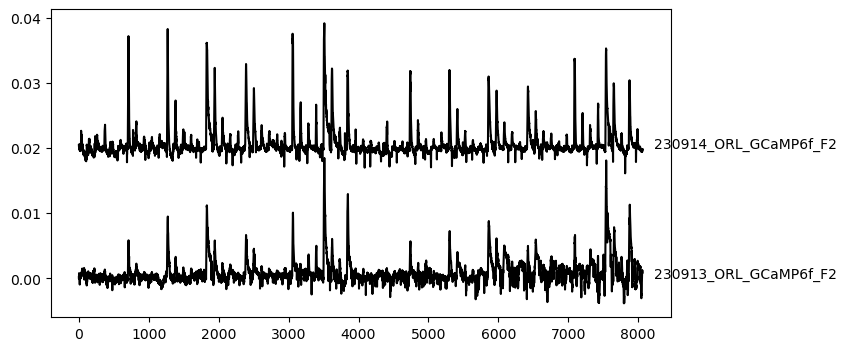

In [4]:
fig, axs = plt.subplots(1, 1, figsize=(8, 4))

for i,samp in enumerate(mean_activity_within_segment):    
    plt.plot(mean_activity_within_segment[samp] + i*0.02, c='black')  # Offset each trace by i*3
    # print sample name on the right
    plt.text(len(mean_activity_within_segment[samp])*1.02, i*0.02, samp, color='black')

# print the names of the odors on the x-axis
odor_names = []
positions = []
for i,index in enumerate(odor_of_interest_indices):
    odor_names.append(odor_encodings[odor_list[index]])
    positions.append(i*params['n_frames_to_analyze'] + params['n_frames_to_analyze']/2)
plt.xticks(positions, odor_names, rotation=90)

# draw vertical lines to separate odors
for i in range(len(odor_of_interest_indices)):
    plt.axvline((i+1)*params['n_frames_to_analyze'], color="black", linestyle="--", alpha=0.1)

plt.yticks([])
# supress grid lines
plt.grid(False)
sns.despine()

plt.savefig(f'{results_dir}/signal_traces.png', dpi=300)
plt.close()


## For each odor, using the mean activity traces, get the maximum intensity during the frames corresponding to that odor.

0.0


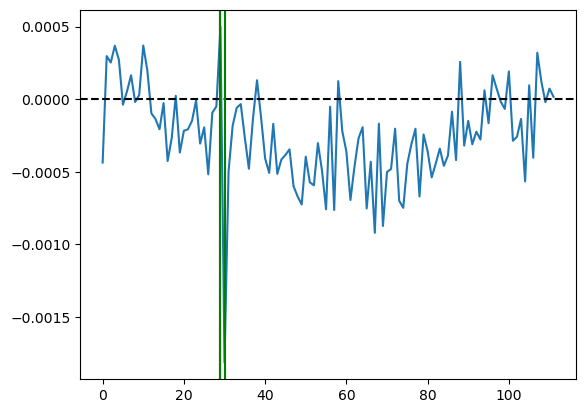

In [39]:
# # reload the functions module to make sure we are using the latest version
# import importlib
# importlib.reload(fn)

maxs_by_samp = fn.compute_max_responses(mean_activity_within_segment, odor_of_interest_indices, odor_list, odor_encodings, params['n_frames_to_analyze'])
aucs_by_samp = fn.calculate_AUC(mean_activity_within_segment, odor_of_interest_indices, odor_list, odor_encodings, params, test=True)

In [25]:
mean_activity_within_segment_paraffin_subtracted = fn.subtract_paraffin_trace(mean_activity_within_segment, odor_of_interest_indices, odor_list, odor_encodings, params['n_frames_to_analyze'])

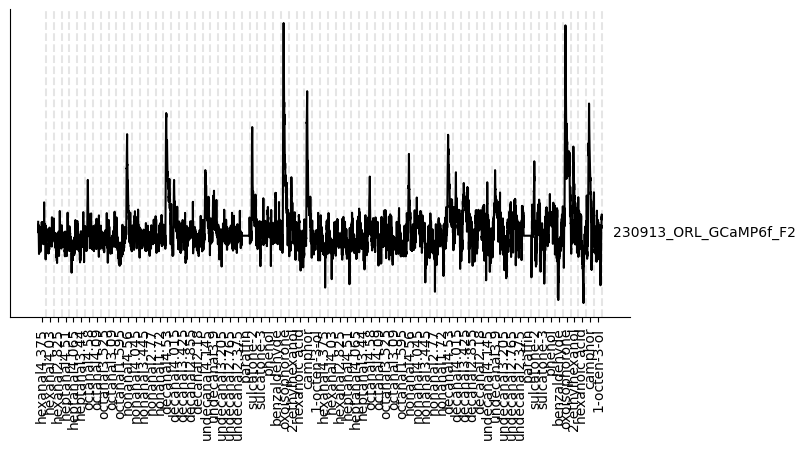

In [26]:
fig, axs = plt.subplots(1, 1, figsize=(8, 4))

for i,samp in enumerate(mean_activity_within_segment_paraffin_subtracted):    
    plt.plot(mean_activity_within_segment_paraffin_subtracted[samp] + i*0.02, c='black')  # Offset each trace by i*3
    # print sample name on the right
    plt.text(len(mean_activity_within_segment_paraffin_subtracted[samp])*1.02, i*0.02, samp, color='black')

# print the names of the odors on the x-axis
odor_names = []
positions = []
for i,index in enumerate(odor_of_interest_indices):
    odor_names.append(odor_encodings[odor_list[index]])
    positions.append(i*params['n_frames_to_analyze'] + params['n_frames_to_analyze']/2)
plt.xticks(positions, odor_names, rotation=90)

# draw vertical lines to separate odors
for i in range(len(odor_of_interest_indices)):
    plt.axvline((i+1)*params['n_frames_to_analyze'], color="black", linestyle="--", alpha=0.1)

plt.yticks([])
# supress grid lines
plt.grid(False)
sns.despine()

In [31]:


maxs_by_samp_paraffin_subtracted = fn.compute_max_responses(mean_activity_within_segment_paraffin_subtracted, odor_of_interest_indices, odor_list, odor_encodings, params['n_frames_to_analyze'])
aucs_by_samp_paraffin_subtracted = fn.calculate_AUC(mean_activity_within_segment_paraffin_subtracted, odor_of_interest_indices, odor_list, odor_encodings, params)

## Convert the data to a DataFrame and save

In [28]:
def convert_to_df(dict, odor_order):
    df_list = []
    for samp in dict:
        df_tmp = pd.DataFrame.from_dict(dict[samp])
        df_tmp['samp'] = samp
        df_tmp['subpop'] = samp.split('_')[1]
        df_tmp['trial'] = df_tmp.index+1
        df_list.append(df_tmp)
    df = pd.concat(df_list)
    df = df.reset_index(drop=True)
    df = pd.melt(df, id_vars=['samp', 'subpop', 'trial'], var_name='odor', value_name='value')
    df['odor_order'] = df['odor'].map(odor_order)
    return df
    
peak_max_df = convert_to_df(maxs_by_samp, odor_order)
peak_auc_df = convert_to_df(aucs_by_samp, odor_order)

peak_max_paraffin_df = convert_to_df(maxs_by_samp_paraffin_subtracted, odor_order)
peak_auc_paraffin_df = convert_to_df(aucs_by_samp_paraffin_subtracted, odor_order)

peak_max_df.to_csv(f'{results_dir}/peak_max_df.csv', index=False)
peak_auc_df.to_csv(f'{results_dir}/peak_auc_df.csv', index=False)
peak_max_paraffin_df.to_csv(f'{results_dir}/peak_max_paraffin_df.csv', index=False)
peak_auc_paraffin_df.to_csv(f'{results_dir}/peak_auc_paraffin_df.csv', index=False)


In [29]:
peak_max_df

,samp,subpop,trial,odor,value,odor_order
0,230913_ORL_GCaMP6f_F2,ORL,1,hexanal4.375,0.001602,0
1,230913_ORL_GCaMP6f_F2,ORL,2,hexanal4.375,0.001477,0
2,230913_ORL_GCaMP6f_F2,ORL,1,hexanal4.03,0.001547,1
3,230913_ORL_GCaMP6f_F2,ORL,2,hexanal4.03,0.000787,1
4,230913_ORL_GCaMP6f_F2,ORL,1,hexanal2.825,0.000752,2
...,...,...,...,...,...,...
67,230913_ORL_GCaMP6f_F2,ORL,2,hexanoic acid,0.003307,33
68,230913_ORL_GCaMP6f_F2,ORL,1,camphor,0.012942,34
69,230913_ORL_GCaMP6f_F2,ORL,2,camphor,0.011308,34
70,230913_ORL_GCaMP6f_F2,ORL,1,1-octen-3-ol,0.001533,35
